# Vehicle-agnostic scene processing for information embedding.

Input data: processed vehicle groups from the highD dataset. See dataviz.ipynb for more info.

In [3]:
import cProfile
import h5py
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import seaborn as sns

from rich import print
from sys import platform
from time import time


sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")

%matplotlib widget

In [8]:
if platform == 'darwin':
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/highD/groups_historic_1000ms/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/highD/groups_historic_1000ms/"
dataset_index = 1 #between 1 and 60
df_groups = pd.read_csv(dataset_location + str(dataset_index).zfill(2) + "_groups.csv")

In [9]:
class PotentialField:
    '''
    A class that represents the occupation information of a frame - See SceneData in dataviz.py.

    Attributes:
        radius_x, radius_y: semiaxis of the ellipse that is considered around the ego vehicle
        step_x, step_y: space discretization in each axis
        df_group_list: a list of vehicle grups as imported by the function read_groups of read_csv.py
    '''
    def __init__(self, radius_x, radius_y, step_x, step_y, df_group_list):
        self.rx, self.ry = radius_x, radius_y
        self.sx, self.sy = step_x, step_y
        self.df_group_list = df_group_list

        self.grid = self.initialize_grid()
        self.field_list = [None]*len(self.df_group_list)

    def initialize_grid(self):
        '''
        Initializes a potential field grid and calculates the number of pixels that the final image will have.
        
        Parameters:
                None
            Returns:
                A grid initialized to zero with size (num_y, num_x)
        '''
        #calculate grid size
        self.num_x = int(2*self.rx / self.sx) + 1
        self.num_y = int(2*self.ry / self.sy) + 1
        self.grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        self.x_pos, self.y_pos = np.linspace(-self.rx, self.rx, self.num_x), np.linspace(-self.ry, self.ry, self.num_y) #x and y interchanged so x is the horizontal dimension, and y is the vertical dimension
        print("Initialized grid of shape: {}".format(self.grid.shape))
        return self.grid

    def group_to_list(self, group):
        '''
        Converts the group from dataframe to dictionary and casts every value to float for future manipulation.
        
        Parameters:
                None
            Returns:
                A list of dictionaries in which each element contains the information of an entry of the dataframe. Order is preserved.
        '''

        self.vehicle_list = group.to_dict(orient='records')
        for idx, vehicle in enumerate(self.vehicle_list):
            for k, v in vehicle.items():
                self.vehicle_list[idx][k] = float(v)
        return self.vehicle_list

    def get_field_value(self, x, y, a, b, c, k):
        '''
        Calculates the value of a potential field along two linespace inputs: x and y coordinates. 
        See https://stackoverflow.com/a/22778484 for magic around empty dimensions - I still don't understand how, but it works.
        
        Parameters:
                x, y: linespaces along which the field is calculated. Positions are relative to the vehicle that is being considered, 
                      which is itself relative to the ego vehicle
                k, a, b, c: parameters of the gaussian - amplitude and exponent coefficients. 
                            The calculation of a, b and c is done from standard deviations and angle of rotation
            Returns:
                A numpy array of size (num_y, num_x) in which each element is the value of the potential field evaluated 
                in the corresponding coordinate of the input linespaces
        '''
        local_grid = k * np.exp(-(a * np.square(x[None,:]) + 2 * b * x[None,:] * y[:,None] + c * np.square(y[:,None])))
        return local_grid
    
    def calculate_field(self):
        '''
        Calculates the value of a potential field associated to an ego vehicle in the context of its group
        
        Parameters:
                None
            Returns:
                A numpy array of size (num_y, num_x) in which each element is the value of the potential field evaluated 
                in the corresponding coordinate of the input linespaces
        '''
        self.grid = np.zeros([self.num_y, self.num_x], dtype = np.float32) #x dimension is rows, y dimension is columns
        for vehicle in self.vehicle_list:
            x_rel = vehicle["x"] - self.x_ego
            y_rel = - vehicle["y"] + self.y_ego #positive y direction points "downwards"
            dx, dy = self.x_pos - x_rel, self.y_pos - y_rel
            ang = np.arctan2(vehicle["xVelocity"], vehicle["yVelocity"])
            sigma_y, sigma_x = vehicle["width"], vehicle["height"]/2
            a = np.square(np.cos(ang)) / (2 * np.square(sigma_x)) + np.square(np.sin(ang)) / (2 * np.square(sigma_y))
            b = - np.sin(2 * ang) / (4 * np.square(sigma_x)) + np.sin(2 * ang) / (4 * np.square(sigma_y))
            c = np.square(np.sin(ang)) / (2 * np.square(sigma_x)) + np.square(np.cos(ang)) / (2 * np.square(sigma_y))
            k = np.linalg.norm([vehicle["xVelocity"], vehicle["yVelocity"]])
            self.grid = np.add(self.grid, self.get_field_value(dx, dy, a, b, c, k))
        return self.grid
    
    def calculate_field_list(self):
        '''
        Performs potential field calculations for every group in df_group_list
        
        Parameters:
                None
            Returns:
                An np.array in which each element is the potential field representation of the associated group.
        '''
        for idx, group in enumerate(self.df_group_list.groupby["historical_aggregation_index"]):
            if not (idx%1000):
                print("Processing group {} of {}".format(idx, self.df_group_list["historical_aggregation_index"].nunique()))
            ego_vehicle_id = group.iloc[0].id
            group["frame"] = group["frame"] - group["frame"].min()
            for inner_group in group.grouby("frame"):
                self.ego_vehicle = inner_group[inner_group["id"] == ego_vehicle_id]
                self.x_ego, self.y_ego = self.ego_vehicle["x"], self.ego_vehicle["y"]
                self.field_list[idx] = self.calculate_field()
        self.field_list = np.array(self.field_list, dtype = np.float32)

        return self.field_list
    
    def save_to_hdf5(self, train_ratio, val_ratio, hdf5_file):
        """
        Split a list of NumPy arrays into train, validation, and test datasets and save them to an HDF5 file.

        :param image_list: List of NumPy arrays (images).
        :param train_ratio: Ratio of data to allocate for training (e.g., 0.7 for 70%).
        :param val_ratio: Ratio of data to allocate for validation (e.g., 0.15 for 15%).
        :param hdf5_file: Name of the HDF5 file to save the datasets.
        """
        if train_ratio + val_ratio >= 1.0:
            raise ValueError("The sum of train_ratio and val_ratio should be less than 1.0.")
        
        total_samples = len(self.field_list)
        train_size = int(total_samples * train_ratio)
        val_size = int(total_samples * val_ratio)

        #np.random.shuffle(field_list)
        # Split the data into train, validation, and test sets
        train_data = self.field_list[:train_size]
        val_data = self.field_list[train_size:train_size + val_size]
        test_data = self.field_list[train_size + val_size:]

        #reescale the images for saving
        train_max, train_min = np.max(train_data), np.min(train_data)

        train_data  = 255 * (train_data - train_min) / (train_max - train_min)
        val_data  = 255 * (val_data - train_min) / (train_max - train_min)
        test_data  = 255 * (test_data - train_min) / (train_max - train_min)

        train_data = train_data.astype(np.uint8)
        val_data = val_data.astype(np.uint8)
        test_data = test_data.astype(np.uint8)
        metadata = {'train_max': train_max, 'train_min': train_min}

        # Save the datasets to an HDF5 file
        with h5py.File(hdf5_file, "w") as hf:
            hf.create_dataset("train", data=train_data)
            hf.create_dataset("validation", data=val_data)
            hf.create_dataset("test", data=test_data)
            for key, value in metadata.items():
                hf.attrs[key] = value
        
    def plot_field(self, idx = None):
        '''
        Plots a 3d graph and a heat map of the potential field of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''

        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig = plt.figure(figsize=(15, 8))

        #plot 3d field
        ax3d = fig.add_subplot(1, 2, 1, projection='3d')
        X, Y = np.meshgrid(self.x_pos, self.y_pos)
        surf = ax3d.plot_surface(X, Y, self.field_list[idx], cmap = "viridis")
        ax3d.set_xlabel("Longitudinal axis (m)")
        ax3d.set_ylabel("Transversal axis (m)")
        ax3d.set_zlabel("Potential field magnitude (-)")
        ax3d.set_title("3d plot - Normalized between 0 and 1")
        fig.colorbar(surf, orientation = 'horizontal', pad = 0.2)

        #plot heatmap
        ax2d = fig.add_subplot(1, 2, 2)
        img = ax2d.imshow(self.field_list[idx])
        ax2d.set_xlabel("Longitudinal axis (px)")
        ax2d.set_ylabel("Transversal axis (px)")
        ax2d.set_title("Potential field heat map")
        fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

        fig.suptitle("Potential field representation")
        plt.show()

    def plot_center_field(self, idx):
        '''
        Plots the value of the potential field in the longitudinal axis of the ego vehicle of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''
        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig, ax = plt.subplots()
        y_index = int((self.field_list[idx].shape[0] - 1) / 2)
        x = self.x_pos
        y = self.self.field_list[idx][y_index]
        ax.plot(x, y)
        ax.set_xlabel("Transversal axis (m)")
        ax.set_ylabel("Potential field magnitude (-)")
        ax.set_title("Ego vehicle longitudinal axis - Frame {}".format(int(self.ego_vehicle["frame"])))

        plt.show()

    def plot_heat_map(self):
        '''
        Plots the heat map of the potential field of a given group in the variable idx.
        
        Parameters:
                idx: index of the group that will be represented
            Returns:
                None
        '''
        if idx is None:
            idx = np.random.randint(len(self.field_list))
        fig, ax = plt.subplots()
        ax.imshow(self.self.field_list[idx])
        ax.set_xlabel("Longitudinal axis (m)")
        ax.set_ylabel("Transversal axis (m)")
        ax.set_title("Potential field heat map - Frame {}".format(int(self.ego_vehicle["frame"])))
        plt.show()

In [10]:
rx = 50 # horizontal semiaxis of ellipse to consider as ROI
ry = 6 # vertical semiaxis of ellipse to consider as ROI
sx = 0.5
sy = 0.1
df_groups.head(40)

,Index,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,...,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId,drivingDirection,historical_aggregation_index
0,163,0,3,182.08,21.64,3.94,1.92,35.69,-0.00,0.17,...,7,0,0,0,10,11,0,5,East,1
1,848,0,7,151.54,22.21,4.75,2.02,32.59,-0.27,0.28,...,12,0,0,0,11,0,0,5,East,1
2,1463,0,10,201.31,25.62,9.20,2.50,23.21,0.17,0.17,...,11,1,0,3,0,0,0,6,East,1
3,1695,0,11,181.50,25.49,4.14,1.92,25.07,0.09,-0.29,...,0,1,3,7,0,0,0,6,East,1
4,188,1,3,217.59,21.63,3.94,1.92,35.89,-0.03,0.20,...,7,0,0,0,10,0,11,5,East,1
5,873,1,7,183.96,22.01,4.75,2.02,32.93,-0.15,0.37,...,12,0,0,0,11,0,0,5,East,1
6,1488,1,10,224.51,25.62,9.20,2.50,23.36,-0.09,0.09,...,11,14,0,3,0,0,0,6,East,1
7,1720,1,11,206.24,25.52,4.14,1.92,24.79,-0.06,-0.30,...,0,3,0,7,0,0,0,6,East,1
8,213,2,3,253.59,21.58,3.94,1.92,36.05,-0.04,0.12,...,7,0,0,0,6,10,11,5,East,1
9,713,2,6,288.20,25.53,11.82,2.50,23.31,-0.15,0.04,...,10,14,0,3,0,0,0,6,East,1


In [76]:
start = time()
field = PotentialField(rx, ry, sx, sy, df_groups)
field_list = field.calculate_field_list()
end = time()
print("Time taken is {}".format(end-start))


Initialized grid of shape: (121, 201)

Processing group 0 of 13955

Processing group 1000 of 13955

Processing group 2000 of 13955

Processing group 3000 of 13955

Processing group 4000 of 13955

Processing group 5000 of 13955

Processing group 6000 of 13955

Processing group 7000 of 13955

Processing group 8000 of 13955

Processing group 9000 of 13955

Processing group 10000 of 13955

Processing group 11000 of 13955

Processing group 12000 of 13955

Processing group 13000 of 13955

Time taken is 27.50149393081665

In [72]:
def save_to_hdf5(field_list, train_ratio, val_ratio, hdf5_file):
    """
    Split a list of NumPy arrays into train, validation, and test datasets and save them to an HDF5 file.

    :param image_list: List of NumPy arrays (images).
    :param train_ratio: Ratio of data to allocate for training (e.g., 0.7 for 70%).
    :param val_ratio: Ratio of data to allocate for validation (e.g., 0.15 for 15%).
    :param hdf5_file: Name of the HDF5 file to save the datasets.
    """
    if train_ratio + val_ratio >= 1.0:
        raise ValueError("The sum of train_ratio and val_ratio should be less than 1.0.")
    
    total_samples = len(field_list)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)

    #np.random.shuffle(field_list)
    # Split the data into train, validation, and test sets
    train_data = field_list[:train_size]
    val_data = field_list[train_size:train_size + val_size]
    test_data = field_list[train_size + val_size:]

    #reescale the images for saving
    train_max, train_min = np.max(train_data), np.min(train_data)
    print("Global max and min of train data are: {}".format((train_min, train_max)))
    train_data  = 255 * (train_data - train_min) / (train_max - train_min)
    val_data  = 255 * (val_data - train_min) / (train_max - train_min)
    test_data  = 255 * (test_data - train_min) / (train_max - train_min)
    print(np.max(train_data), np.min(train_data))
    plt.imshow(train_data[0])
    train_data = train_data.astype(np.uint8)
    val_data = val_data.astype(np.uint8)
    test_data = test_data.astype(np.uint8)
    metadata = {'train_max': train_max, 'train_min': train_min}
    plt.imshow(train_data[0])
    plt.show()
    # Save the datasets to an HDF5 file
    with h5py.File(hdf5_file, "w") as hf:
        hf.create_dataset("train", data=train_data)
        hf.create_dataset("validation", data=val_data)
        hf.create_dataset("test", data=test_data)
        for key, value in metadata.items():
            hf.attrs[key] = value


Global max and min of train data are: (0.0, 50.220222)

254.99998 0.0

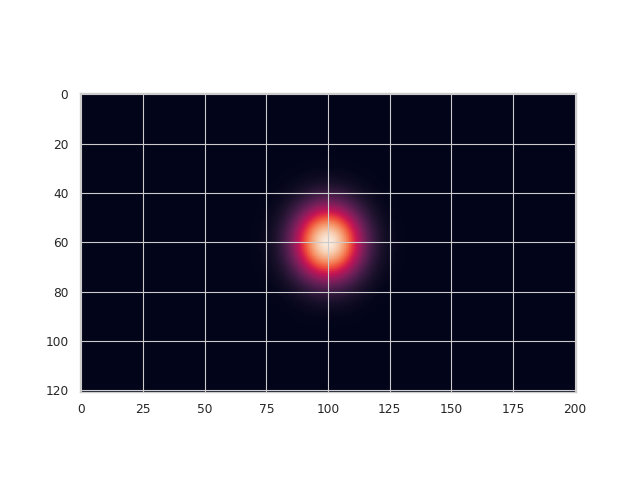

In [77]:
split_and_save_to_hdf5(field_list=field_list, train_ratio=0.6, val_ratio=0.2, hdf5_file='/home/lmmartinez/containers/tensorflow_gpu/Tesis/datasets/highD/images_int/01_images.hdf5')

In [59]:
def load_hdf5_dataset(dataset_path):
    """
    Load a dataset from an HDF5 file and return Keras-compatible data.

    :param dataset_path: Path to the HDF5 file.
    :return: Tuple (train_data, validation_data, test_data) and metadata dictionary.
    """
    with h5py.File(dataset_path, "r") as hf:
        # Load train, validation, and test datasets
        train_data = np.array(hf["train"], dtype = np.uint8)
        validation_data = np.array(hf["validation"])
        test_data = np.array(hf["test"])
        metadata = {}
        for key, value in hf.attrs.items():
            metadata[key] = value

    return train_data, validation_data, test_data, metadata

{'train_max': 50.220222, 'train_min': 0.0}

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

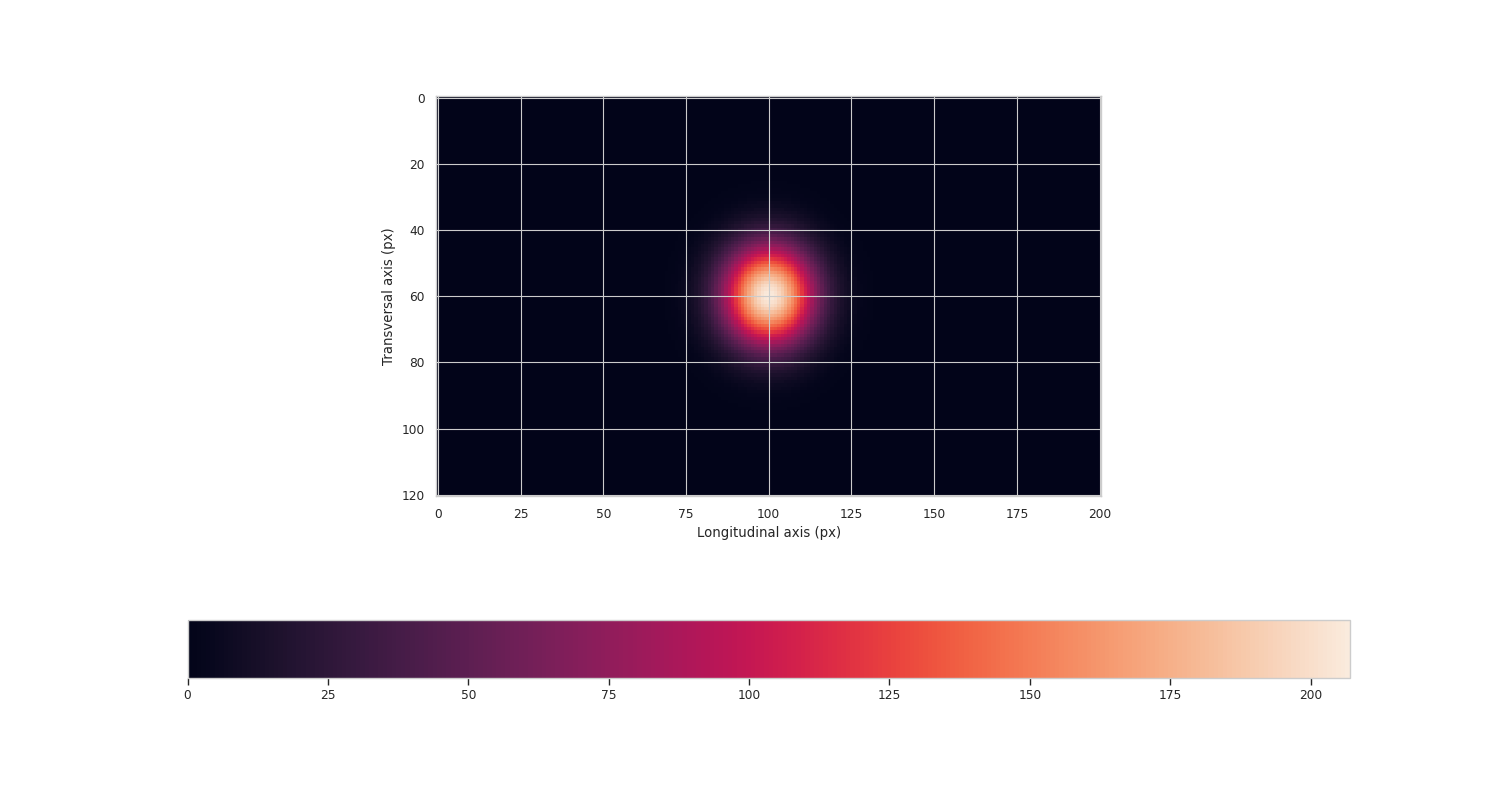

In [78]:
dataset_path = '/home/lmmartinez/containers/tensorflow_gpu/Tesis/datasets/highD/images_int/01_images.hdf5'  # Replace with the path to your HDF5 file
train_data, validation_data, test_data, metadata = load_hdf5_dataset(dataset_path)

print(metadata)
fig = plt.figure(figsize=(15, 8))
#plot heatmap
ax2d = fig.add_subplot()
display(train_data[0])
img = ax2d.imshow(train_data[0])
ax2d.set_xlabel("Longitudinal axis (px)")
ax2d.set_ylabel("Transversal axis (px)")
fig.colorbar(img, orientation = 'horizontal', pad = 0.2)

plt.show()

In [67]:
plt.close('all')